In [1]:
import bisect
# go to the parent folder
import os

import matplotlib.pyplot as plt

os.chdir("..")

import numpy as np
import pandas as pd
import time

# Our package
from RB_method_for_model_identification.RBForModelIdentification import RBForModelIdentification

# Inference of real data

In this example, we consider a data set from real experiments. Potentially, the circuit can be described by a two gene-state model as follows:
\begin{align}
&\text{Gene Activation:} && G \to G^* && \text{Propensity:} ~ k_{1} X_G \\
&\text{Gene Deactivation:} && G^* \to G && \text{Propensity:} ~ k_{2} X_{G^*} \\
&\text{mRNA Transcription:} && \emptyset \to \text{mRNA} && \text{Propensity:} ~ k_{p1} X_{G^*} \\
&\text{mRNA Degration:} &&\text{mRNA} \to \emptyset && \text{Propensity:} ~ X_\text{mRNA} \\
\end{align}
the gene can transition between three distinct states, with mRNA being produced when the gene is in either of the two activated states. Additionally, the rate of mRNA degradation is directly proportional to its copy number. Also, the mRNA exhibits fluorescence, allowing for the use of a microscope to record its dynamics very 2 minutes.

leader species:  ['G1']
follower species:  ['mRNA', 'G0']
follower parameters:  ['k1', 'kp1', 'k2']


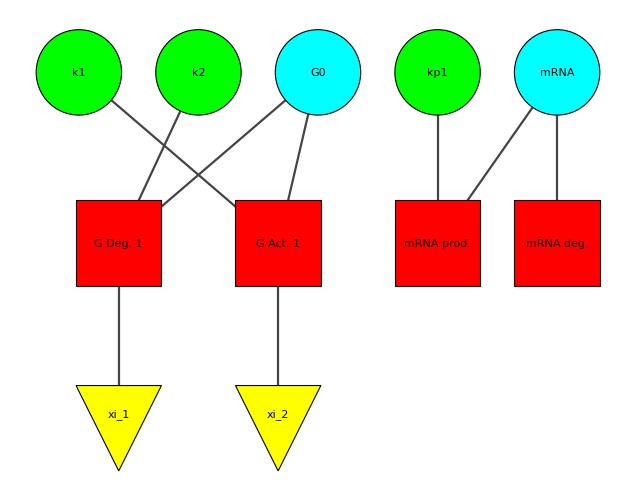

Number of subsystems: 2
-----------------------------------------------------
    xi_1  xi_2
G1    -1     1
-----------------------------------------------------
Subsystem:  1
Involved parameters and species: ['k1', 'k2', 'G0']
Unobservable reactions involved: []
Observable reactions involved: ['G Deg. 1', 'G Act. 1']
Xi involved: ['xi_1', 'xi_2']
Size of state space of this subsystem: 882
-----------------------------------------------------
Subsystem:  2
Involved parameters and species: ['kp1', 'mRNA']
Unobservable reactions involved: ['mRNA prod.', 'mRNA deg.']
Observable reactions involved: []
Xi involved: []
Size of state space of this subsystem: 14641
-----------------------------------------------------


In [2]:
# The network structure
species_names = ['G0', 'G1', 'mRNA']
stoichiometric_matrix = [[-1, 1, 0, 0],
                         [1, -1, 0, 0],
                         [0, 0, 1,-1]]
parameters_names = ['k1','k2', 'kp1']
reaction_names = ['G Act. 1', 'G Deg. 1', 'mRNA prod.', 'mRNA deg.']
propensities = [
    lambda k1, G0: k1*G0,
    lambda k2, G1: k2*G1,
    lambda kp1, G1: kp1*G1,
    lambda mRNA: mRNA
]

range_of_species = \
    pd.DataFrame([[0, 1], [0, 1], [0, 120] ], index=species_names, columns=['min', 'max'])
range_of_parameters= \
    pd.DataFrame([[0, 1], [0, 1], [0, 150]],index=parameters_names,columns=['min', 'max'])
discretization_size_parameters = \
    pd.DataFrame([21, 21, 121], index=parameters_names) #index=parameters_names

# The observation related information
# h_function = [
#     lambda Protein: Protein
# ]
h_function = [
    lambda mRNA: np.where(mRNA > 7, mRNA, 0)
]
observation_noise_intensity = [
    lambda : 1
]
#observation_noise_intensity = {'sigma1': 0.1}

maximum_size_of_each_follower_subsystem = 20000 #800 # 1000


MI = RBForModelIdentification(
    species_names=species_names,
    stoichiometric_matrix=stoichiometric_matrix,
    parameters_names=parameters_names,
    reaction_names=reaction_names,
    propensities=propensities,
    range_of_species=range_of_species,
    range_of_parameters=range_of_parameters,
    observation_noise_intensity=observation_noise_intensity,
    discretization_size_parameters=discretization_size_parameters,
    h_function=h_function,
    maximum_size_of_each_follower_subsystem=maximum_size_of_each_follower_subsystem)

print('leader species: ', MI.leader_species_time_course_data)
print('follower species: ', MI.get_follower_species_time_course_data())
print('follower parameters: ', MI.get_follower_parameters_time_course_data())
MI.leader_follower_decomposition_result_time_course_data.plot_decomposition()

## Load the result

In [4]:
import pickle

# Load the objects from the pickle file
with open(f"Example_of_model_identification/results_in_paper/real_data_2_gene_state_model__cell_index_78_particle_number_3000.pkl", 'rb') as f:
    data = pickle.load(f)


# Create a new object from the dictionary
Marginal_distributions_over_time = data['margin_distributions_over_time']
time_result = data['time_result']
mean_result = data['mean_result']
std_result = data['std_result']
Y_list = data['Y_list']

In [6]:
# plot the observation
def cm_to_inch(value):
    return value/2.54

tf =240
dt = 2
Observation_times_list = np.arange(dt, tf+dt, dt)

# compute the stationary distribution of the infreed model

from CRN_Simulation.MarginalDistribution import MarginalDistribution
Initial_marginal_distributions = MI.generate_uniform_marginal_distributions_via_speceis_range(MI.range_of_species)
delta_distribution = np.zeros((len(Initial_marginal_distributions['mRNA'].states), 1))
delta_distribution[0] = 1
Initial_marginal_distributions['mRNA'].adjust_distribution(delta_distribution)
# initial distribution of G0, G1, G2
Initial_marginal_distributions['G0'].adjust_distribution(np.array([[0], [1]]))
Initial_marginal_distributions['G1'].adjust_distribution(np.array([[1], [0]]))
# Initial_marginal_distributions['G2'].adjust_distribution(np.array([[1], [0]]))

MAP_parameter_dict = {}
for i in range(len(Marginal_distributions_over_time[-1])):
    element = list(Marginal_distributions_over_time[-1][i].parameter_species_ordering.keys())[0]
    if element in MI.parameters_names:
        map_index = np.argmax(Marginal_distributions_over_time[-1][i].distribution_list[-1])
        map_state = Marginal_distributions_over_time[-1][i].states[map_index, 0]
        MAP_parameter_dict.update({element: map_state})


Tf = 100
distribution_inferred_model = MI.FSP(Initial_marginal_distributions, MI.range_of_species, MAP_parameter_dict, 0, Tf, normalization=True)
marginal_distributions_over_time = distribution_inferred_model.extract_marginal_distributions_over_time()
mRNA_distribution_inferred_model = marginal_distributions_over_time[-1]['mRNA'].distribution
mRNA_distribution_inferred_model = mRNA_distribution_inferred_model.flatten()


dx = 10

bins = np.arange(0, 150, dx)
data_distribution= [0]*len(bins)
for i in range(len(bins)-1):
    for j in range(5, len(Y_list)):
        if bins[i] <= Y_list[j] < bins[i+1]:
            data_distribution[i] += 1
data_distribution = np.array(data_distribution)/sum(data_distribution)


new_distribution= [0]*len(bins)

for i in range(len(bins)-1):
    for j in range(len(mRNA_distribution_inferred_model)):
        if bins[i] <= j < bins[i+1]:
            new_distribution[i] += mRNA_distribution_inferred_model[j]

x = [x+dx/2 for x in bins]

weights = np.ones_like(Y_list) / len(Y_list)
# plt.hist(np.array(Y_list[5:]).reshape(-1), weights=weights, bins=bins, edgecolor='black', alpha=0.75, label='data')
x = [x+dx/2 for x in bins]

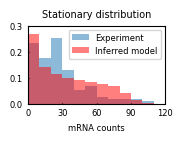

In [7]:
fig = plt.figure(figsize=(cm_to_inch(4.5), cm_to_inch(3)))
#fig = plt.figure(figsize=(cm_to_inch(5), cm_to_inch(3)))
plt.bar(x, data_distribution, width=dx, alpha=0.5, label='Experiment')

plt.bar(x, new_distribution, color='red', width=dx, alpha=0.5, label='Inferred model')
# plt.plot(x, new_distribution, color='red', label='inferred')

plt.legend(loc='upper right', fontsize=6)

plt.tick_params(axis='x', labelsize=6, direction='in', length=1)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)

plt.xlabel( 'mRNA counts', fontsize=6)
# plt.ylabel('Probability', fontsize=6)
plt.title(f'Stationary distribution', fontsize=7)

xticks = np.arange(0, 121, step=30)
plt.xticks(xticks)  # Set the x-ticks
plt.xlim((0, 120))
yticks = np.arange(0, 0.31, step=0.1)
plt.yticks(yticks)  # Set the x-ticks

plt.subplots_adjust(bottom=0.22)

fig.savefig("figure.pdf", format='pdf')

In [9]:
from scipy.stats import entropy

kl_divergence = entropy(data_distribution, new_distribution)
print('KL-divergence:', kl_divergence)

L1_norm = sum(abs(data_distribution - new_distribution))
print('L1 norm:', L1_norm)

KL-divergence: 0.1449226865988822
L1 norm: 0.4199173739097764
